# Fine-Tuning ChemBERTa


https://github.com/seyonechithrananda/bert-loves-chemistry/blob/master/chemberta/examples/ZINC250K_Transfer_Learning_With_HuggingFace_tox21.ipynb


## Libraries


In [326]:
import os
import shutil

import pickle

import numpy as np

import torch
import torch.nn as nn

import pandas as pd

import transformers
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification, AutoModel
from transformers import AutoTokenizer
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import EvalPrediction
from transformers import DataCollatorWithPadding

import datasets
from datasets import load_from_disk
from datasets import concatenate_datasets


import matplotlib.pyplot as plt

from scipy.signal import find_peaks, peak_prominences
from scipy.ndimage import gaussian_filter1d


from huggingface_hub import login

from typing import Optional

## Preamble


In [327]:
# 1. Choose model
MODEL_NAME = "DeepChem/ChemBERTa-5M-MTR"
MODEL_SUFFIX = MODEL_NAME.split("/")[1]


print(f"Model: {MODEL_NAME}")

Dataset: comp
Model: DeepChem/ChemBERTa-5M-MTR


## Datasets


In [328]:
# Dataset folder
DATASET_FOLDER_PATH = "/datasets"

In [329]:
## Need to use the keep_in_memory, because the dataset folder is in read-only

train_dataset_comp = load_from_disk(os.path.join(DATASET_FOLDER_PATH, "train_comp"), keep_in_memory=True)
val_dataset_comp = load_from_disk(os.path.join(DATASET_FOLDER_PATH, "val_comp"), keep_in_memory=True)
test_dataset_comp = load_from_disk(os.path.join(DATASET_FOLDER_PATH, "test_comp"), keep_in_memory=True)


#Load exp dataset
train_dataset_exp = load_from_disk(os.path.join("/storage/train_exp.hf"), keep_in_memory=True)
val_dataset_exp = load_from_disk(os.path.join(DATASET_FOLDER_PATH, f"val_exp"), keep_in_memory=True)
test_dataset_exp = load_from_disk(os.path.join(DATASET_FOLDER_PATH, "test_exp"), keep_in_memory=True)

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [331]:
train_dataset_comp = train_dataset_comp.rename_column("spectrum", "labels")
train_dataset_exp = train_dataset_exp.rename_column("spectrum", "labels")

val_dataset_comp = val_dataset_comp.rename_column("spectrum", "labels")
val_dataset_exp = val_dataset_exp.rename_column("spectrum", "labels")

test_dataset_comp = test_dataset_comp.rename_column("spectrum", "labels")
test_dataset_exp = test_dataset_exp.rename_column("spectrum", "labels")

In [332]:
def preprocess_spectrum(line, sigma=5, cutoff=(0,800)):

    if cutoff is not None:
        spectrum = line["labels"][cutoff[0]:cutoff[1]]
    else:
        spectrum = line['labels']
    
    peaks_prominences = peak_prominences(spectrum, range(len(spectrum)))[0]


    line['labels'] = gaussian_filter1d(peaks_prominences, sigma)

    line['labels'] = 10000 * line['labels']/sum(line['labels'])

    return line

In [333]:
sigma_preprocess = 15 #Sigma for the gaussian filter
cutoff_preprocess = None #Use this value as (a;b) if you want to build a model in the [a;b] region of the spectrum

num_labels_model = cutoff_preprocess[1]- cutoff_preprocess[0] if cutoff_preprocess is not None else 1801

15 None 1801


In [334]:
train_dataset_comp = train_dataset_comp.map(preprocess_spectrum, fn_kwargs={'sigma': sigma_preprocess, 'cutoff':cutoff_preprocess})
train_dataset_exp = train_dataset_exp.map(preprocess_spectrum, fn_kwargs={'sigma': sigma_preprocess, 'cutoff':cutoff_preprocess})

val_dataset_comp = val_dataset_comp.map(preprocess_spectrum, fn_kwargs={'sigma': sigma_preprocess, 'cutoff':cutoff_preprocess})
val_dataset_exp = val_dataset_exp.map(preprocess_spectrum, fn_kwargs={'sigma': sigma_preprocess, 'cutoff':cutoff_preprocess})

test_dataset_comp = test_dataset_comp.map(preprocess_spectrum, fn_kwargs={'sigma': sigma_preprocess, 'cutoff':cutoff_preprocess})
test_dataset_exp = test_dataset_exp.map(preprocess_spectrum, fn_kwargs={'sigma': sigma_preprocess, 'cutoff':cutoff_preprocess})

Map:   0%|          | 0/68404 [00:00<?, ? examples/s]

/tmp/ipykernel_92/3025805659.py:8: PeakPropertyWarning: some peaks have a prominence of 0
  peaks_prominences = peak_prominences(spectrum, range(len(spectrum)))[0]


Map:   0%|          | 0/48000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

## Tokenizer


In [335]:
# Models at https://huggingface.co/DeepChem

HF_TOKEN = "" #HF Login Token goes here

model_cache = "/storage/smiles2spec_models/"

In [336]:
login(HF_TOKEN)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [337]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, cache_dir=model_cache)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [338]:
def tokenize(batch):
    
    tokens = tokenizer(batch['smiles'])
    
    return tokens

In [339]:
train_dataset_comp = train_dataset_comp.map(tokenize, batched=True)
train_dataset_exp = train_dataset_exp.map(tokenize, batched=True)

val_dataset_comp = val_dataset_comp.map(tokenize, batched=True)
val_dataset_exp = val_dataset_exp.map(tokenize, batched=True)

test_dataset_comp = test_dataset_comp.map(tokenize, batched=True)
test_dataset_exp = test_dataset_exp.map(tokenize, batched=True)

Map:   0%|          | 0/68404 [00:00<?, ? examples/s]

Map:   0%|          | 0/48000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

In [340]:
train_dataset_comp.set_format('torch')
train_dataset_exp.set_format('torch')

val_dataset_comp.set_format('torch')
val_dataset_exp.set_format('torch')

test_dataset_comp.set_format('torch')
test_dataset_exp.set_format('torch')

In [341]:
train_dataset_mix = concatenate_datasets([train_dataset_comp, train_dataset_exp]) # type: ignore
val_dataset_mix = concatenate_datasets([val_dataset_comp, val_dataset_exp]) # type: ignore

train_dataset = train_dataset_mix.shuffle(seed=42)
val_dataset = val_dataset_mix.shuffle(seed=42)

In [342]:
train_dataset = train_dataset.remove_columns(["base", "shift"])
val_dataset = val_dataset.remove_columns(["base", "shift"])
test_dataset_exp = test_dataset_exp.remove_columns(["base", "shift"])

In [343]:
train_dataset, val_dataset, test_dataset_comp, test_dataset_exp

(Dataset({
     features: ['smiles', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 116404
 }),
 Dataset({
     features: ['smiles', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 14551
 }),
 Dataset({
     features: ['smiles', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 8551
 }),
 Dataset({
     features: ['smiles', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 6000
 }))

## Base Model


In [344]:
print("Model Name : ", MODEL_SUFFIX)

Model Name :  ChemBERTa-5M-MTR


In [345]:
class Smile2Spec(nn.Module):
    def __init__(self, model_name, num_labels) -> None:
        super().__init__()

        self.LLM = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        
        self.activation = torch.exp



    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.LLM(input_ids, attention_mask=attention_mask)


        outputs = self.activation(outputs.logits)

        return outputs

In [346]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels_model)
print(model)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-5M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(600, 384, padding_idx=1)
      (position_embeddings): Embedding(515, 384, padding_idx=1)
      (token_type_embeddings): Embedding(1, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.144, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-2): 3 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.109, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
             

## Training


In [347]:
NB_EPOCHS = 10
BATCH_SIZE = 64 # cf. seyonechithrananda
RESULTS_FOLDER = os.path.join(model_cache, f"peak_classification/{MODEL_SUFFIX}")

In [348]:
training_args = TrainingArguments(
    f"peak_detection_{MODEL_SUFFIX}",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NB_EPOCHS,
    report_to="none",
    remove_unused_columns = True
)

data_collator = DataCollatorWithPadding(tokenizer)

In [349]:
class SIDLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, model_spectra, target_spectra, threshold = 10e-12):

        model_spectra[model_spectra <= threshold] = threshold
        target_spectra[target_spectra <= threshold] = threshold


        loss = torch.ones_like(target_spectra)

        loss = torch.mul(torch.log(torch.div(model_spectra, target_spectra)), model_spectra) \
                + torch.mul(torch.log(torch.div(target_spectra, model_spectra)), target_spectra)
        
        loss = torch.sum(loss, dim=1)

        return loss.mean()

In [350]:
class CustomTrainer(Trainer):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
   
    def compute_loss(self, model, inputs, return_outputs=False):
        
        labels = inputs.get("labels")
        outputs = model(**inputs).logits
        loss_fct = SIDLoss()
        loss = loss_fct(outputs, labels)
        
        return (loss, {"label": outputs}) if return_outputs else loss

In [351]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset, # type: ignore
    eval_dataset = val_dataset,
    tokenizer=tokenizer,
    data_collator = data_collator)

In [352]:
trainer.train()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,39295.204000
1000,10753.242000
1500,10524.919000
2000,9920.662000
2500,9029.049000
3000,8412.166000
3500,8090.448000
4000,7924.975000
4500,7749.562000
5000,7586.624000


TrainOutput(global_step=18190, training_loss=8029.887067069819, metrics={'train_runtime': 1132.7116, 'train_samples_per_second': 1027.658, 'train_steps_per_second': 16.059, 'total_flos': 1957979986872480.0, 'train_loss': 8029.887067069819, 'epoch': 10.0})

## Results


In [353]:
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(600, 384, padding_idx=1)
      (position_embeddings): Embedding(515, 384, padding_idx=1)
      (token_type_embeddings): Embedding(1, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.144, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-2): 3 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.109, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
             

In [354]:
def plot_example(dataset, index):
    smile = dataset['smiles'][index]
    labels = dataset['labels'][index]

    inputs = tokenizer(smile, return_tensors='pt')
    inputs = inputs.to(torch.device('cuda'))

    preds = model(**inputs).logits.flatten().cpu().detach().numpy()

    plt.figure(figsize=(14,5))
    plt.plot(labels, label='true spectrum')
    plt.plot(preds, label='predicted spectrum')

    plt.title(smile)

    plt.legend(loc='upper right')

    plt.show()

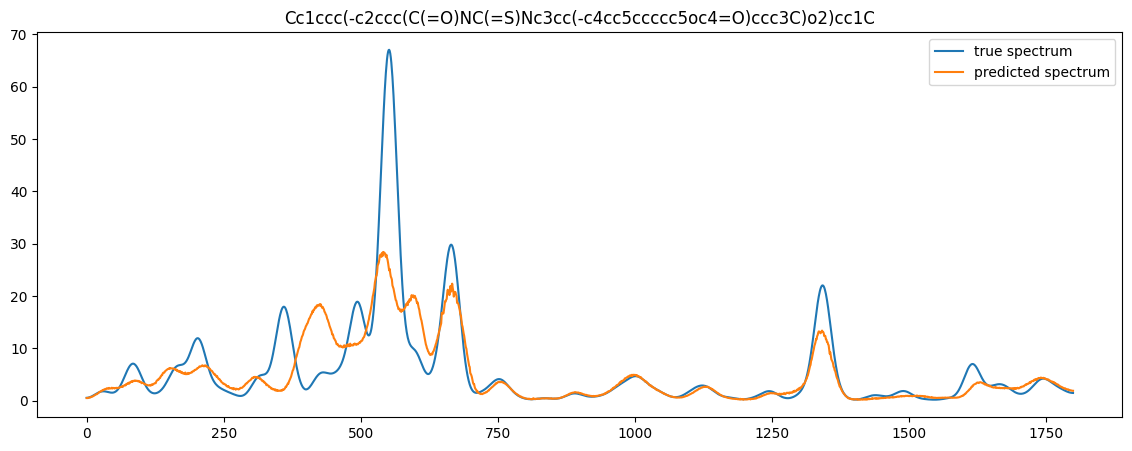

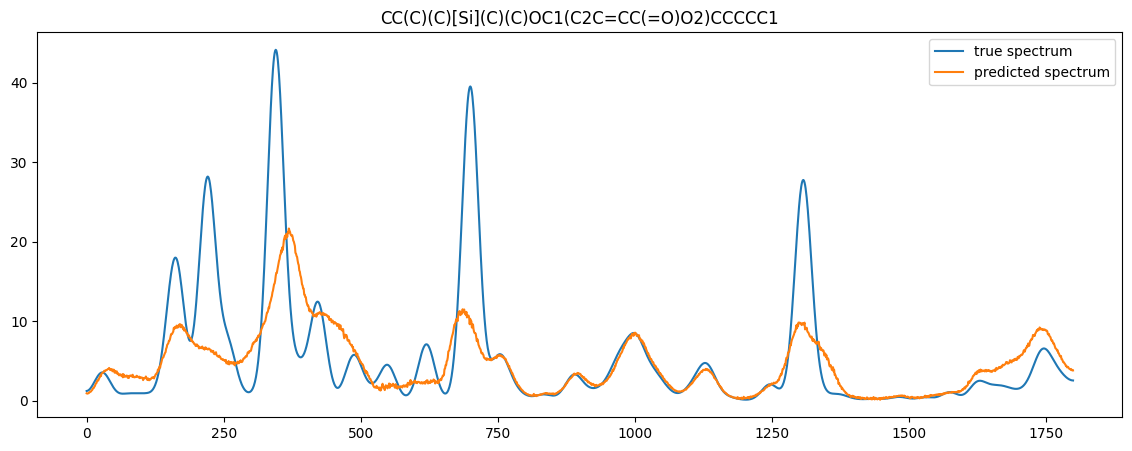

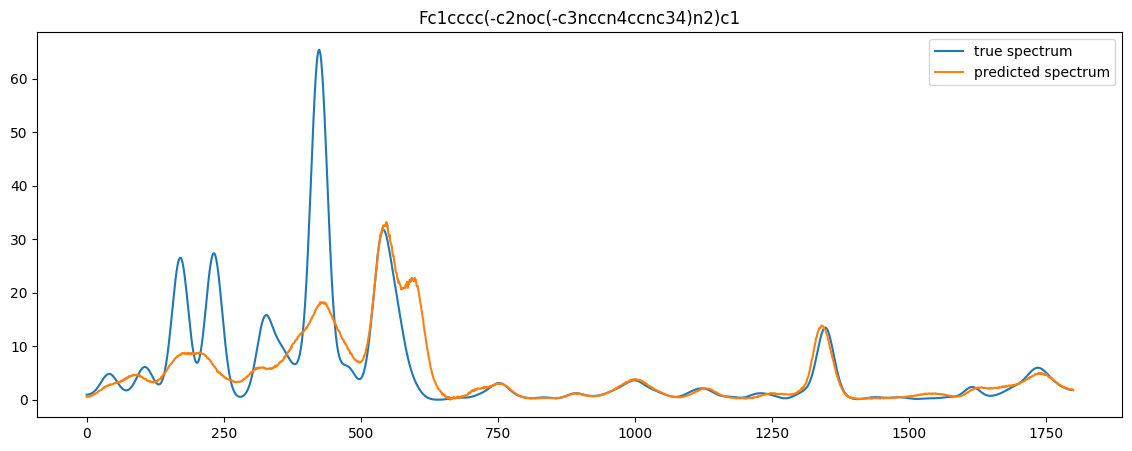

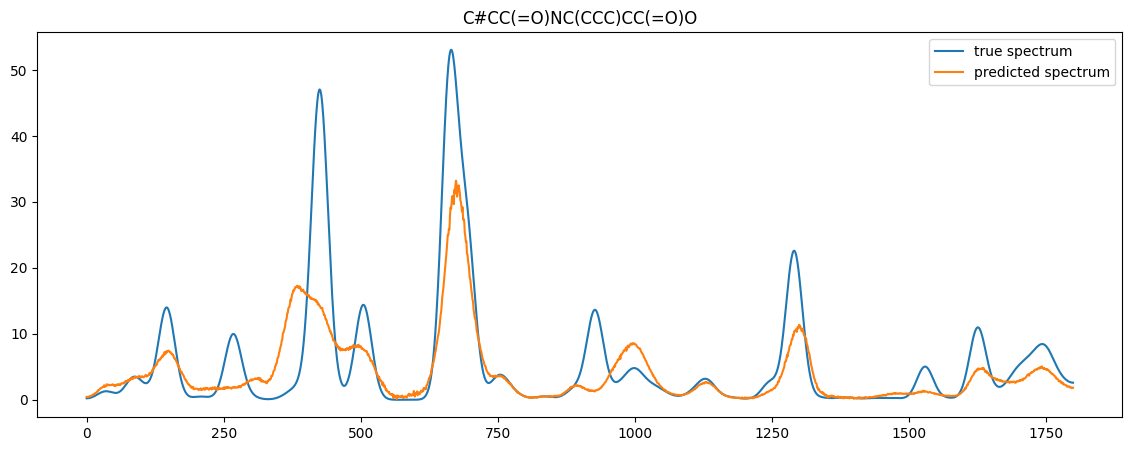

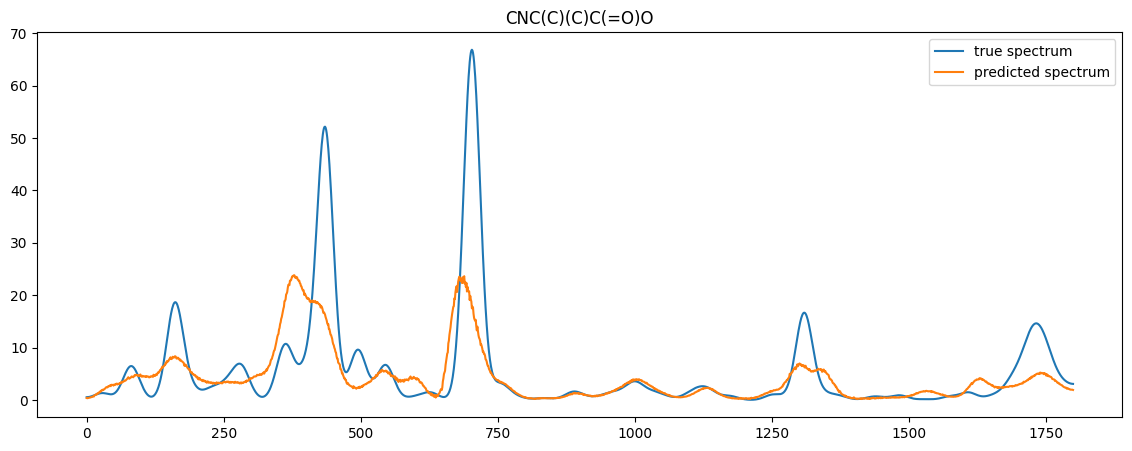

In [355]:
for _ in range(5):
    plot_example(test_dataset_comp, np.random.randint(len(test_dataset_comp)))

# Results


In [358]:
class SIDLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, model_spectra, target_spectra, threshold = 10e-12):

        model_spectra[model_spectra <= threshold] = threshold
        target_spectra[target_spectra <= threshold] = threshold


        loss = torch.ones_like(target_spectra)

        loss = torch.mul(torch.log(torch.div(model_spectra, target_spectra)), model_spectra) \
                + torch.mul(torch.log(torch.div(target_spectra, model_spectra)), target_spectra)
        
        loss = torch.sum(loss, dim=1)

        return loss

def get_SIS(y, y_hat):
    """spectral information similarity (SIS)
    """
    
    #Gaussian Convolution
    y_hat_conv = gaussian_filter1d(y_hat, 5)
    y_conv = gaussian_filter1d(y, 5)

    #Normalization
    y_hat_conv = nn.functional.normalize(torch.tensor(y_hat_conv), p=1)
    y_conv = nn.functional.normalize(torch.tensor(y_conv), p=1)
    
    #Initialize SID Class
    SID = SIDLoss()
    
    SIDs = SID(y_hat_conv, y_conv)

    SISs = 1/(1+SIDs)

    std, mean = torch.std_mean(SISs)
    
    return SISs, mean.item(), std.item()

def get_SID(y, y_hat):
    """spectral information divergence"""

    SID = SIDLoss()
    
    SIDs = SID(y_hat, y)

    std, mean = torch.std_mean(SIDs)

    return SIDs, mean.item(), std.item()

In [359]:
test_dataset_comp['labels'].shape

torch.Size([8551, 1801])

In [360]:
metrics = {}

for data_suffix in ['comp', 'exp']:

    test_dataset = test_dataset_comp if data_suffix=='comp' else test_dataset_exp 

    evaluate = trainer.predict(test_dataset)

    metrics[f'test_{data_suffix}_truths'] = evaluate.label_ids

    metrics[f'test_{data_suffix}_preds'] = evaluate.predictions

In [361]:
for data_suffix in ['comp', 'exp']:


    y = torch.from_numpy(metrics[f"test_{data_suffix}_truths"])
    y_hat = torch.from_numpy(metrics[f"test_{data_suffix}_preds"])


    SIDs, SID_mean, SID_std = get_SID(y, y_hat)
    metrics[f"SIDs_{data_suffix}"] = SIDs
    metrics[f"SID_{data_suffix}"] = SID_mean, SID_std

    SISs, SIS_mean, SIS_std = get_SIS(y, y_hat)
    metrics[f"SISs_{data_suffix}"] = SISs
    metrics[f"SIS_{data_suffix}"] = SIS_mean, SIS_std

In [362]:
def plot_distribution(metrics, mean_std, data_suffix=None):
    """Plot distribution of a given metrics and save it as pdf"""
    
    mean, std = mean_std
    
    plt.figure(figsize=(4.5,3))
    plt.hist(metrics, bins=50, density=True, 
             edgecolor='black', 
             linewidth=0.5,
             color="C1",
             alpha=0.5,
             label=f"mean: {mean:.4f}\nstd: {std:.4f}")

    plt.title(f"results: {data_suffix}. test set")
    plt.legend()

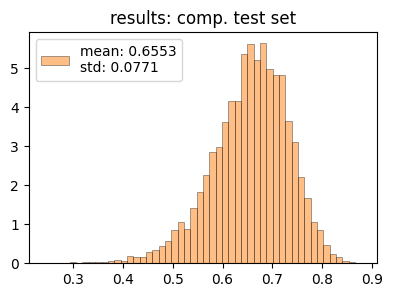

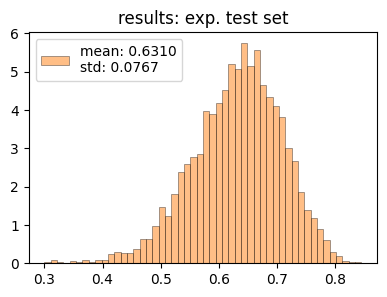

In [363]:
for data_suffix in ['comp', 'exp']:
    plot_distribution(metrics[f'SISs_{data_suffix}'], mean_std = metrics[f'SIS_{data_suffix}'], data_suffix=data_suffix)

tensor(0.8783)


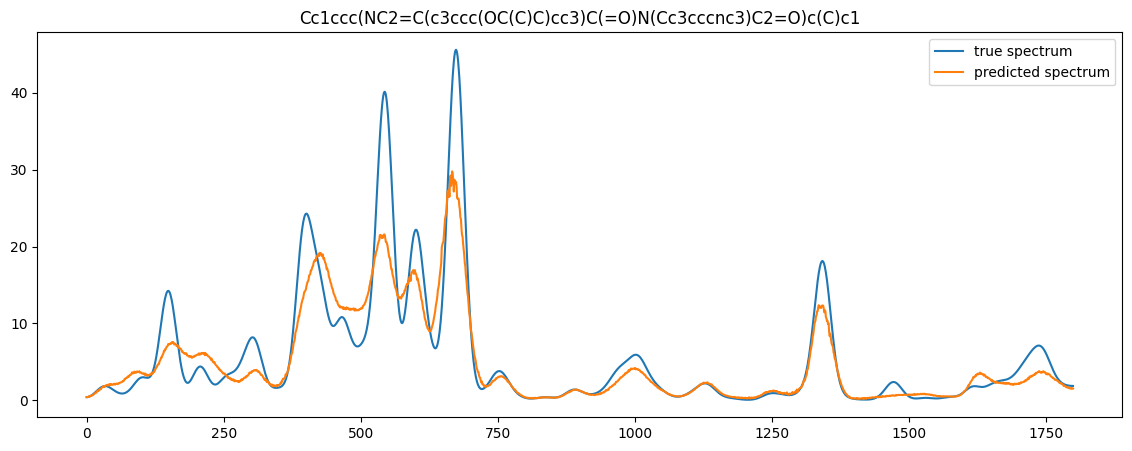

In [364]:
max_index = torch.argmax(metrics['SISs_comp'])
print(torch.max(metrics['SISs_comp']))

smile = test_dataset_comp['smiles'][max_index]
labels = test_dataset_comp['labels'][max_index]

inputs = tokenizer(smile, return_tensors='pt')
inputs = inputs.to(torch.device('cuda'))

preds = model(**inputs).logits.flatten().cpu().detach().numpy()

plt.figure(figsize=(14,5))
plt.plot(labels, label='true spectrum')
plt.plot(preds, label='predicted spectrum')

plt.title(smile)

plt.legend(loc='upper right')

plt.show()

tensor(0.8448)


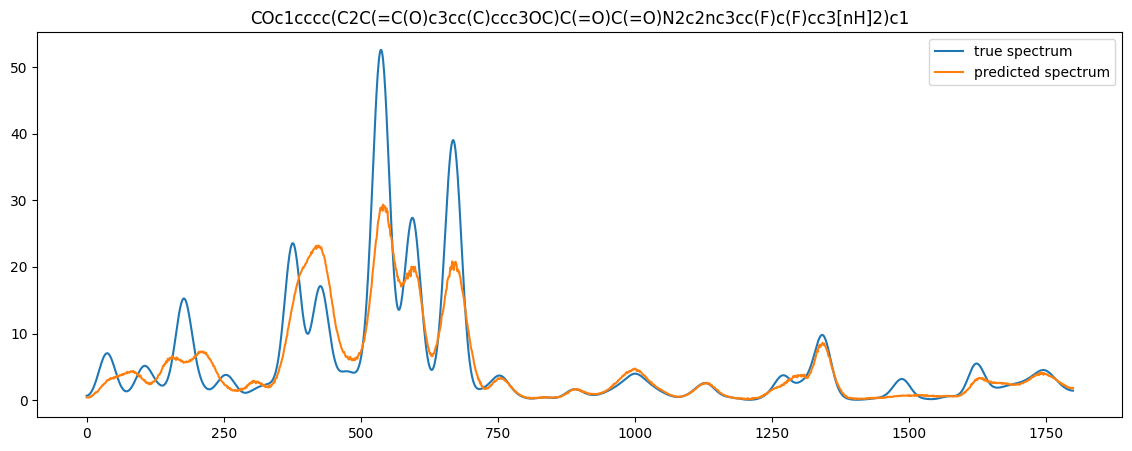

In [365]:
max_index = torch.argmax(metrics['SISs_exp'])
print(torch.max(metrics['SISs_exp']))

smile = test_dataset_exp['smiles'][max_index]
labels = test_dataset_exp['labels'][max_index]

inputs = tokenizer(smile, return_tensors='pt')
inputs = inputs.to(torch.device('cuda'))

preds = model(**inputs).logits.flatten().cpu().detach().numpy()

plt.figure(figsize=(14,5))
plt.plot(labels, label='true spectrum')
plt.plot(preds, label='predicted spectrum')

plt.title(smile)

plt.legend(loc='upper right')

plt.show()